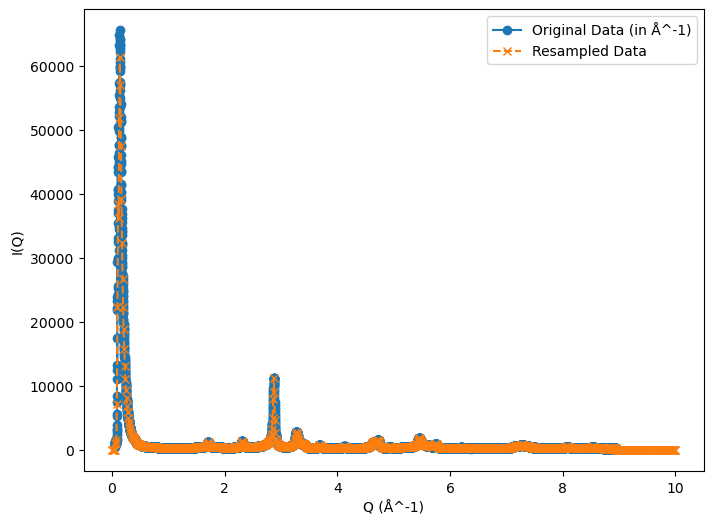

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Replace with your actual file path
file_path = 'ESRF_IB_06_0002_q_PtHEI.xye'

# Initialize lists for Q and I(Q)
q_values_nm = []
i_values = []

# Reading the file and extracting Q and I(Q) values
with open(file_path, 'r') as f:
    for line in f:
        if not line.startswith('#'):  # Skip comment lines
            parts = line.split()
            if len(parts) == 3:  # Ensure it's a data line
                q_values_nm.append(float(parts[0]))  # Q in nm^-1
                i_values.append(float(parts[1]))  # Intensity

# Convert to numpy arrays
q_values_nm = np.array(q_values_nm)
i_values = np.array(i_values)

# Convert Q from nm^-1 to Å^-1 (multiply by 10)
q_values_angstrom = q_values_nm * 0.1

# Define the Q-range in Å^-1 and the number of points for resampling
q_min = 0.0  # Example minimum Q in Å^-1
q_max = 10.0  # Example maximum Q in Å^-1
num_points = 1000  # Example number of points for resampling

# Create new Q values for the desired range in Å^-1
new_q_values = np.linspace(q_min, q_max, num_points)

# Interpolate the I(Q) values to fit the new Q range
interpolator = interp1d(q_values_angstrom, i_values, kind='linear', bounds_error=False, fill_value=0)
new_i_values = interpolator(new_q_values)

# Plot the original and resampled data for comparison
plt.figure(figsize=(8, 6))
plt.plot(q_values_angstrom, i_values, label='Original Data (in Å^-1)', marker='o')
plt.plot(new_q_values, new_i_values, label='Resampled Data', marker='x', linestyle='--')
plt.xlabel('Q (Å^-1)')
plt.ylabel('I(Q)')
plt.legend()
plt.show()

# Now you can use the resampled Q and I(Q) values for further processing
iq_exp = new_i_values.copy()
iq_exp[:100] = 0.0
iq_exp = iq_exp / np.max(iq_exp)

from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.io.cif import CifParser

# Conditional imports for backwards compatibility with older pymatgen versions
try:
    parser_from_string = CifParser.from_str
except AttributeError:
    parser_from_string = CifParser.from_string

def calculate_xrd(cif_string, xrd_params):
    try:
        # Parse the CIF string to get the structure
        structure = parser_from_string(cif_string).get_structures()[0]
        
        # Initialize the XRD calculator using the specified wavelength
        xrd_calculator = XRDCalculator(wavelength=xrd_params['wavelength'])
        
        # Calculate the XRD pattern from the structure
        xrd_pattern = xrd_calculator.get_pattern(structure)
    
    except Exception as e:
        raise e
        return None
    
    # Convert 2θ (xrd_pattern.x) to Q (momentum transfer)
    theta_radians = np.radians(xrd_pattern.x / 2)
    q_values = 4 * np.pi * np.sin(theta_radians) / xrd_calculator.wavelength
    
    # Normalize intensities
    intensities_normalized = xrd_pattern.y / (np.max(xrd_pattern.y) + 1e-16)
    
    # Define the continuous Q grid
    q_continuous = np.arange(xrd_params['qmin'], xrd_params['qmax'], xrd_params['qstep'])
    
    # Initialize the continuous intensity array
    intensities_continuous = np.zeros_like(q_continuous)
    
    # Apply Gaussian broadening to the peaks
    for q_peak, intensity in zip(q_values, xrd_pattern.y):
        gaussian_broadening = intensity * np.exp(-0.5 * ((q_continuous - q_peak) / xrd_params['fwhm']) ** 2)
        intensities_continuous += gaussian_broadening
    
    # Normalize the continuous intensities
    intensities_continuous /= (np.max(intensities_continuous) + 1e-16)
    
    # Add noise to the signal if the SNR is less than 100
    if xrd_params['snr'] < 100.:
        noise = np.random.normal(0, np.max(intensities_continuous) / xrd_params['snr'], size=intensities_continuous.shape)
        intensities_continuous = np.clip(intensities_continuous + noise, 0, None)

    return {'q': q_continuous, 'iq': intensities_continuous}

In [80]:
import numpy as np
import pandas as pd
import torch

from decifer import (
    DeciferDataset,
    Decifer,
    DeciferConfig,
    load_model_from_checkpoint,
    Tokenizer,
    extract_prompt,
    replace_symmetry_loop_with_P1,
    extract_space_group_symbol,
    reinstate_symmetry_loop,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model_from_checkpoint('../deep_conditioning/ckpt.pt', device)
model.eval()

number of total parameters: 25.75M


Decifer(
  (transformer): ModuleDict(
    (cond_embedding): Sequential(
      (0): Linear(in_features=1000, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
    )
    (wte): Embedding(372, 512)
    (wpe): Embedding(1024, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=False)
          (c_proj): Linear(in_features=512, out_features=512, bias=False)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=512, out_features=2048, bias=False)
          (c_proj): Linear(in_features=2048, out_features=512, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): Layer

Generating sequence:   0%|          | 0/1000 [00:00<?, ?it/s]

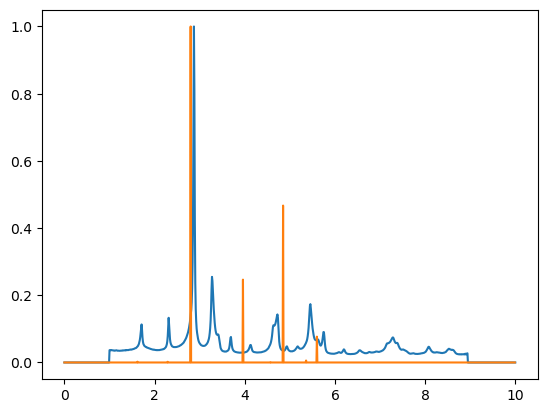

In [87]:
padding_id = Tokenizer().padding_id
decode = Tokenizer().decode
tok = Tokenizer()
prompt_ids = [tok.token_to_id[i] for i in ["data_"]]

with torch.no_grad():
    
    prompt = torch.tensor([prompt_ids]).to(model.device)
    cond_vec = torch.from_numpy(iq_exp).to(model.device, dtype=torch.float32).unsqueeze(0)
    token_ids = model.generate_batched_reps(prompt, max_new_tokens=1000, cond_vec=cond_vec, start_indices_batch=[[0]]).cpu().numpy()
    token_ids = [ids[ids != padding_id] for ids in token_ids]  # Remove padding tokens

    out_cif = decode(list(token_ids[0]))
    out_cif = replace_symmetry_loop_with_P1(out_cif)

    # Extract space group symbol from the CIF string
    spacegroup_symbol = extract_space_group_symbol(out_cif)

    # If the space group is not "P1", reinstate symmetry
    if spacegroup_symbol != "P 1":
        out_cif = reinstate_symmetry_loop(out_cif, spacegroup_symbol)
        
xrd_params = {
    'wavelength': 'CuKa',
    'qmin': 0.0,
    'qmax': 10.0,
    'qstep': 0.01,
    'fwhm': 0.001,
    'snr': 100,
}
out_dict = calculate_xrd(out_cif, xrd_params)
fig, ax = plt.subplots()
ax.plot(new_q_values, iq_exp)
ax.plot(out_dict['q'], out_dict['iq'])